In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import json
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/green_academy/data/filtered_custom_tmdb.csv')

In [ ]:
mv_ids = df1['id'].tolist()

In [ ]:
%pip install surprise

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/green_academy/data/ml-25m/ratings.csv')
# ratings.head()

In [ ]:
links = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/green_academy/data/ml-25m/links.csv')

In [ ]:
a = df1[['id', 'imdb_id']].copy()
a['id'] = a['id'].astype(int)

In [ ]:
# a[a['imdb_id'].isna()]

In [ ]:
# links[links['tmdbId']==836466]

In [ ]:
a['imdb_id'] = a['imdb_id'].dropna().str.replace(r'tt', '').astype(int)

In [ ]:
tmdb_id_check = links[links['tmdbId'].isin(a['id'])]
imdb_id_check = links[links['imdbId'].isin(a['imdb_id'])]

In [ ]:
tmdb_id_check.shape, imdb_id_check.shape

((4367, 3), (4367, 3))

In [ ]:
tmdb_id_check['tmdbId'] = tmdb_id_check['tmdbId'].astype(int)

<ipython-input-14-51d54151310f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb_id_check['tmdbId'] = tmdb_id_check['tmdbId'].astype(int)


In [ ]:
ratings2 = pd.merge(ratings, links[['movieId', 'tmdbId']], on='movieId', how='left')

In [ ]:
ratings3 = ratings2[ratings2['tmdbId'].isin(tmdb_id_check['tmdbId'])].dropna()
ratings3['tmdbId'] = ratings3['tmdbId'].astype(int)
ratings3.head()

,userId,movieId,rating,timestamp,tmdbId
0,1,296,5.0,1147880044,680
1,1,306,3.5,1147868817,110
2,1,307,5.0,1147868828,108
4,1,899,3.5,1147868510,872
5,1,1088,4.0,1147868495,88


In [ ]:
ratings3['rating'].describe()

count    1.980853e+07
mean     3.584918e+00
std      1.047013e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

## **사용자별 평균 평점 기준 보정값으로 변경**

In [ ]:
ratings3['rating_divided_by_user_average'] = ratings3['rating']/ratings3.groupby('userId')['rating'].transform('mean')

In [ ]:
avg_rating_per_user = ratings3.groupby('userId')['rating'].mean()

In [ ]:
ratings3[['rating']].describe()

,rating
count,1.980853e+07
mean,3.584918e+00
std,1.047013e+00
min,5.000000e-01
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [ ]:
ratings3[['rating_divided_by_user_average']].describe()

,rating_divided_by_user_average
count,1.980853e+07
mean,1.000000e+00
std,2.799786e-01
min,1.005025e-01
25%,8.542373e-01
50%,1.026181e+00
75%,1.172851e+00
max,6.666667e+00


<Axes: >

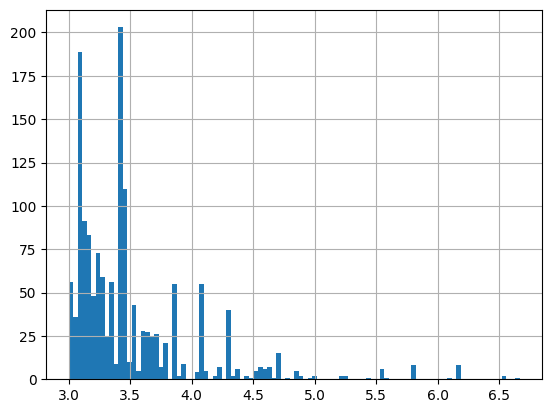

In [ ]:
ratings3[ratings3['rating_divided_by_user_average'] >= 3]['rating_divided_by_user_average'].hist(bins=100)

### **데이터 Scaler 적용**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmaxscaler = MinMaxScaler(feature_range=(0, 5))
ratings3[['minmax_scaled_rating_divided_by_user_average']] = minmaxscaler.fit_transform(ratings3[['rating_divided_by_user_average']])
standardscaler = StandardScaler()
ratings3[['standard_scaled_rating_divided_by_user_average']] = standardscaler.fit_transform(ratings3[['rating_divided_by_user_average']])

In [ ]:
ratings3[['minmax_scaled_rating_divided_by_user_average']].describe()

,minmax_scaled_rating_divided_by_user_average
count,1.980853e+07
mean,6.849490e-01
std,2.131980e-01
min,0.000000e+00
25%,5.739536e-01
50%,7.048853e-01
75%,8.165712e-01
max,5.000000e+00


In [ ]:
ratings3[['standard_scaled_rating_divided_by_user_average']].describe()

,standard_scaled_rating_divided_by_user_average
count,1.980853e+07
mean,-8.723839e-15
std,1.000000e+00
min,-3.212737e+00
25%,-5.206209e-01
50%,9.351069e-02
75%,6.173711e-01
max,2.023964e+01


### **Cross Validate**

In [ ]:
svd = SVD()

In [ ]:
data = Dataset.load_from_df(ratings3[['userId', 'tmdbId', 'rating']], Reader(rating_scale=(0.5, 5)))
result = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7713  0.7706  0.7715  0.7709  0.7713  0.7711  0.0003  
MAE (testset)     0.5801  0.5796  0.5803  0.5797  0.5800  0.5800  0.0003  
Fit time          105.65  144.10  128.37  130.77  124.14  126.61  12.42   
Test time         33.72   33.62   32.59   31.70   31.29   32.58   0.98    


In [ ]:
min_max_scaled_data = Dataset.load_from_df(ratings3[['userId', 'tmdbId', 'minmax_scaled_rating_divided_by_user_average']], Reader(rating_scale=(0, 5)))
result = cross_validate(svd, min_max_scaled_data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

In [ ]:
std_scaled_data = Dataset.load_from_df(ratings3[['userId', 'tmdbId', 'standard_scaled_rating_divided_by_user_average']], Reader(rating_scale=(-3.212737e+00
, 2.023964e+01)))
std_result = cross_validate(svd, std_scaled_data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8167  0.8161  0.8167  0.8161  0.8161  0.8163  0.0003  
MAE (testset)     0.6023  0.6023  0.6026  0.6020  0.6021  0.6022  0.0002  
Fit time          123.88  120.89  127.05  113.38  105.27  118.09  7.85    
Test time         38.47   37.13   31.67   31.20   30.95   33.88   3.23    


In [ ]:
from surprise import BaselineOnly
data = Dataset.load_from_df(ratings3[['userId', 'tmdbId', 'rating']], Reader(rating_scale=(0.5, 5)))
baseline_algo = BaselineOnly()

In [ ]:
result = cross_validate(baseline_algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8563  0.8552  0.8558  0.8562  0.8560  0.8559  0.0004  
MAE (testset)     0.6529  0.6523  0.6525  0.6529  0.6527  0.6527  0.0002  
Fit time          5.94    6.07    6.12    5.96    6.16    6.05    0.09    
Test time         23.70   23.65   23.98   24.27   23.59   23.84   0.25    


In [ ]:
trainset = data.build_full_trainset()
baseline_algo.fit(trainset)

Estimating biases using als...


In [ ]:
pred = baseline_algo.predict(1, 307, verbose=True)

user: 1          item: 307        r_ui = None   est = 4.11   {'was_impossible': False}


In [ ]:
def predict_baseline_rating(row):
    return baseline_algo.predict(row['userId'], row['tmdbId']).est

In [ ]:
ratings3['baseline_rating'] = ratings3.apply(predict_baseline_rating, axis=1)

In [ ]:
ratings3[['baseline_rating']].describe()

,baseline_rating
count,1.980853e+07
mean,3.582018e+00
std,5.862238e-01
min,5.000000e-01
25%,3.226854e+00
50%,3.639357e+00
75%,3.997006e+00
max,5.000000e+00


In [ ]:
baseline_data = Dataset.load_from_df(ratings3[['userId', 'tmdbId', 'baseline_rating']], Reader(rating_scale=(0.5, 5)))
svd = SVD()
result = cross_validate(svd, baseline_data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

In [ ]:
trainset = min_max_scaled_data.build_full_trainset()
svd.fit(trainset)

In [ ]:
avg_rating_per_user

userId
1         3.869048
2         3.648387
3         3.686414
4         3.368534
5         3.957746
            ...   
162537    4.054054
162538    3.412752
162539    4.511628
162540    3.929487
162541    3.420000
Name: rating, Length: 162540, dtype: float64

In [ ]:
svd.predict(1, 307, 1.292308)

Prediction(uid=1, iid=307, r_ui=1.292308, est=0.9954702939962257, details={'was_impossible': False})

In [ ]:
ratings3.head()

,userId,movieId,rating,timestamp,tmdbId,rating_divided_by_user_average
0,1,296,5.0,1147880044,680,1.292308
1,1,306,3.5,1147868817,110,0.904615
2,1,307,5.0,1147868828,108,1.292308
4,1,899,3.5,1147868510,872,0.904615
5,1,1088,4.0,1147868495,88,1.033846


In [ ]:
ratings3[ratings3['userId']==1].describe()

,userId,movieId,rating,timestamp,tmdbId,rating_divided_by_user_average
count,42.0,42.000000,42.000000,4.200000e+01,42.000000,42.000000
mean,1.0,6089.571429,3.869048,1.147871e+09,1713.595238,1.000000
std,0.0,6572.395551,0.956745,4.366213e+03,5500.980503,0.247282
min,1.0,296.000000,0.500000,1.147868e+09,12.000000,0.129231
25%,1.0,1742.500000,3.500000,1.147869e+09,143.250000,0.904615
50%,1.0,5208.000000,4.000000,1.147869e+09,614.500000,1.033846
75%,1.0,7321.750000,4.500000,1.147869e+09,840.250000,1.163077
max,1.0,27721.000000,5.000000,1.147880e+09,34584.000000,1.292308


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/green_academy/models/minmax_svd_tmdb_movies.pkl', 'wb') as file:
    pickle.dump(svd, file)

In [ ]:
movies_in_ratings = ratings3['tmdbId'].unique()
movies_all = a['id']

In [ ]:
b = movies_all[~np.isin(movies_all, movies_in_ratings)]

In [ ]:
b.shape

(612,)

In [ ]:
a.shape

(4976, 2)

In [ ]:
ratings3['userId'].unique().shape, ratings3['movieId'].unique().shape

((162540,), (4367,))

In [ ]:
ratings3[ratings3['userId'] == 1].sort_values('rating', ascending=False).reset_index(drop=True)[:10]

,userId,movieId,rating,timestamp,tmdbId
0,1,296,5.0,1147880044,680
1,1,2692,5.0,1147869100,104
2,1,7361,5.0,1147880055,38
3,1,6711,5.0,1147868622,153
4,1,6016,5.0,1147869090,598
5,1,4144,5.0,1147868898,843
6,1,3949,5.0,1147868678,641
7,1,8154,5.0,1147868865,439
8,1,307,5.0,1147868828,108
9,1,1237,5.0,1147868839,490
